In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) 

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 

In [ ]:
download_dir = Path('/content/drive/MyDrive/RTK/498R/Dataset')

In [ ]:
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'

class_subset = sorted(os.listdir('/content/drive/MyDrive/RTK/498R/Dataset/test'))[:10] 

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 4066 images belonging to 10 classes.
Found 710 images belonging to 10 classes.
Found 1199 images belonging to 10 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 30

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)

     |████████████████████████████████| 138 kB 4.7 MB/s 
0.5.3


In [ ]:
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

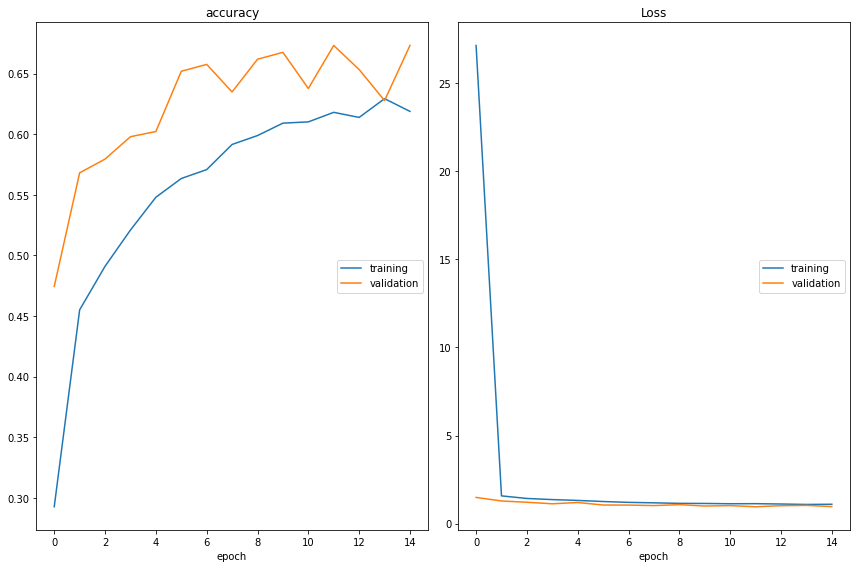

accuracy
	training         	 (min:    0.293, max:    0.629, cur:    0.619)
	validation       	 (min:    0.474, max:    0.673, cur:    0.673)
Loss
	training         	 (min:    1.090, max:   27.136, cur:    1.102)
	validation       	 (min:    0.961, max:    1.489, cur:    0.968)
60/60 [==============================] - 2758s 46s/step - loss: 1.1021 - accuracy: 0.6189 - val_loss: 0.9681 - val_accuracy: 0.6733


In [ ]:
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=15,
                            validation_data=validgen,
                            steps_per_epoch=60,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 75.15%


In [ ]:
from keras.models import load_model

scratch_model = load_model('/content/tl_model_v1.weights.best.hdf5')

scratch_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

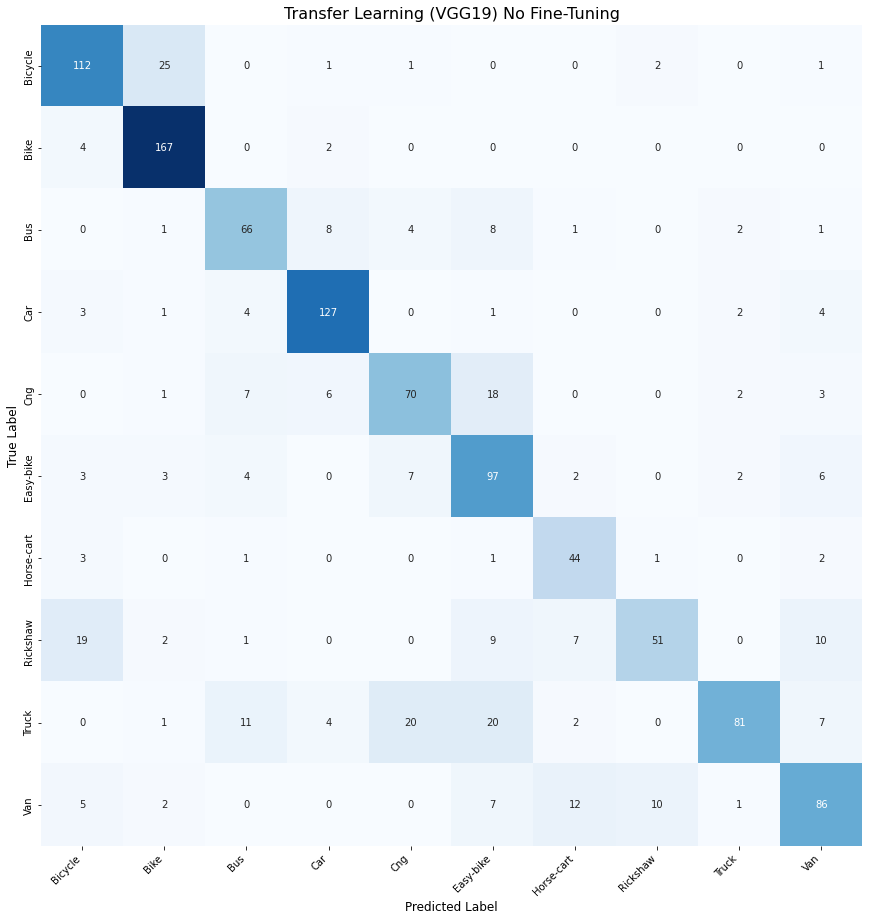

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax2) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG19) No Fine-Tuning")      

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_classes,vgg_pred_classes))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       142
           1       0.82      0.97      0.89       173
           2       0.70      0.73      0.71        91
           3       0.86      0.89      0.88       142
           4       0.69      0.65      0.67       107
           5       0.60      0.78      0.68       124
           6       0.65      0.85      0.73        52
           7       0.80      0.52      0.63        99
           8       0.90      0.55      0.69       146
           9       0.72      0.70      0.71       123

    accuracy                           0.75      1199
   macro avg       0.75      0.74      0.74      1199
weighted avg       0.76      0.75      0.75      1199



In [ ]:
cm = confusion_matrix(true_classes, vgg_pred_classes)
TP = cm.diagonal()

precision_micro = TP.sum()/cm.sum()
recall_micro = TP.sum()/cm.sum()

precision_macro = np.nanmean(TP/cm.sum(0))
recall_macro = np.nanmean(TP/cm.sum(1))

print("")
print("Calculated:")
print("precision_micro:", precision_micro)
print("precision_macro:", precision_macro)
print("recall_micro:", recall_micro)
print("recall_macro:", recall_macro)


Calculated:
precision_micro: 0.7514595496246872
precision_macro: 0.7483933190603427
recall_micro: 0.7514595496246872
recall_macro: 0.7425441781615156


In [ ]:
f1 = (2*precision_macro*recall_macro)/(recall_macro+precision_macro)

print("F1 macro:",f1)

F1 macro: 0.7454572751422834
